In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
WORK_DIR = '/content/drive/My Drive/FINA4350'
DATA_DIR = f'{WORK_DIR}/datasets/cashcowputer-dataset'

In [0]:
import tensorflow as tf
import tensorflow_hub as hub

In [0]:
module_path = 'https://tfhub.dev/google/universal-sentence-encoder/3'

In [0]:
embed = hub.load(module_path)

In [0]:
messages = [
    "The quick brown fox jumps over the lazy dog.",
    "I am a sentence for which I would like to get its embedding",
    "That band rocks!",
    "That song is really cool."]

In [0]:
message_embeddings = embed(messages)['outputs']

In [0]:
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

In [0]:
args = {
    'numberOfOutputClasses': 1,
    'embed_size': 512,
    'loss': 'binary_crossentropy',
    'optimizer': 'adam',
    'epochs': 20,
    'batch_size': 256,
    'activation': 'relu',
    'output_acitivation': 'sigmoid',
    'model_name': 'DAN-2-DNN-keras'
}

In [0]:
def UniversalEmbedding(x):
    return embed(tf.squeeze(tf.cast(x, tf.string)))['outputs']

In [0]:
input_text = layers.Input(shape=(1,), dtype=tf.string)
embedding = layers.Lambda(UniversalEmbedding, output_shape=(args['embed_size'],))(input_text)
dropout = layers.Dropout(0.1)(embedding)
dense = layers.Dense(256, activation=args['activation'])(dropout)
dropout1 = layers.Dropout(0.1)(dense)
pred = layers.Dense(args['numberOfOutputClasses'], args['output_acitivation'])(dropout1)
model = Model(inputs=[input_text], outputs=pred)
model.compile(loss=args['loss'], optimizer=args['optimizer'], metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
lambda (Lambda)              (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 131,585
Trainable params: 131,585
Non-trainable params: 0
_______________________________________________________

In [0]:
import pandas as pd
sentiment_df = pd.read_csv(f'{DATA_DIR}/preprocessed/revamped_preprocessed_tweet_senti_dataset.csv')

In [0]:
sentiment_df.head()

,Sentiment,cleaned_text
0,0,is so sad for my apl friend
1,0,i missed the new moon trailer
2,1,omg its already time surprise
3,0,omgaga i am so i am gunna cry i have been at t...
4,0,i think mi bf is cheating on me tt


In [0]:
sentiment_df.isnull().values.any()

True

In [0]:
sentiment_df.dropna(axis=0,inplace=True)

In [0]:
assert(sentiment_df.isnull().values.any() == False)

In [0]:
sentiment_df[sentiment_df.isnull().values]

,Sentiment,cleaned_text


In [0]:
from sklearn.model_selection import train_test_split
import numpy as np
sentiments = sentiment_df.Sentiment.values
tweets = sentiment_df.cleaned_text.values

In [0]:
x_train, x_test, y_train, y_test = train_test_split(tweets, sentiments, test_size=.2)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=.2)

In [0]:
history = model.fit(x_train, 
          y_train,
          validation_data=(x_val, y_val),
          epochs=args['epochs'],
          batch_size=args['batch_size'])
# save as JSON
json_string = model.to_json()
model.save_weights(f"{WORK_DIR}/models/{args['model_name']}.h5")
import json
with open(f"{WORK_DIR}/models/{args['model_name']}_args.json", 'w') as f:
    json.dump(args, f)
with open(f"{WORK_DIR}/models/{args['model_name']}.json", 'w') as f:
    json.dump(json_string, f)

Train on 1010271 samples, validate on 252568 samples
Epoch 1/20
1010271/1010271 [==============================] - 155s 153us/sample - loss: 0.4883 - accuracy: 0.7644 - val_loss: 0.4699 - val_accuracy: 0.7755
Epoch 2/20
1010271/1010271 [==============================] - 144s 143us/sample - loss: 0.4729 - accuracy: 0.7745 - val_loss: 0.4644 - val_accuracy: 0.7786
Epoch 3/20
1010271/1010271 [==============================] - 144s 142us/sample - loss: 0.4670 - accuracy: 0.7784 - val_loss: 0.4648 - val_accuracy: 0.7790
Epoch 4/20
1010271/1010271 [==============================] - 143s 141us/sample - loss: 0.4633 - accuracy: 0.7805 - val_loss: 0.4604 - val_accuracy: 0.7820
Epoch 5/20
1010271/1010271 [==============================] - 150s 149us/sample - loss: 0.4603 - accuracy: 0.7825 - val_loss: 0.4594 - val_accuracy: 0.7824
Epoch 6/20
1010271/1010271 [==============================] - 147s 145us/sample - loss: 0.4578 - accuracy: 0.7838 - val_loss: 0.4586 - val_accuracy: 0.7828
Epoch 7/20


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


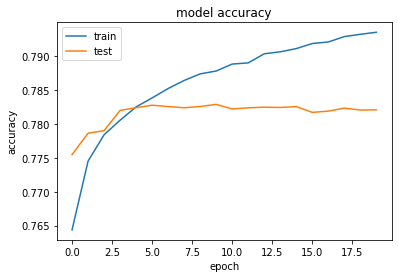

In [0]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

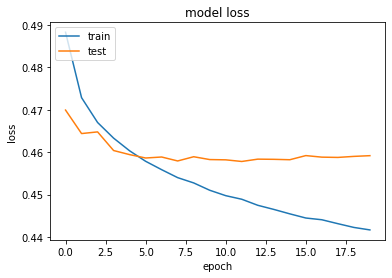

In [0]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
score = model.evaluate(x_test, y_test, verbose=1)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [0]:
score

[0.4601276972882065, 0.7824649]